# COMP90086 Computer Vision Final Project  

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Process data

In [3]:
from components.DataProcessor import DataProcessor


file_path = 'COMP90086_2023_TLLdataset/train.csv'
test_file_path = 'COMP90086_2023_TLLdataset/test_candidates.csv'
save_path = 'dictionaries'
dataset_base_path = 'COMP90086_2023_TLLdataset'

processor = DataProcessor(file_path, test_file_path, save_path, dataset_base_path)
processor.load_data()
processor.split_data()
processor.generate_dictionaries()
processor.save_dictionaries()
processor.process_test_candidates()

Dictionaries saved to 'dictionaries/train_dict.pkl' and 'dictionaries/val_dict.pkl'
Dictionaries saved to dictionaries/test_dict.pkl


In [4]:
train_data = load_pkl('dictionaries/train_dict.pkl')
val_data = load_pkl('dictionaries/val_dict.pkl')
test_data = load_pkl('dictionaries/test_dict.pkl')

print('train data size: ', len(train_data))
print('val data size: ', len(val_data))
print('test data size: ', len(test_data))

train data size:  1600
val data size:  400
test data size:  2000


In [5]:
# print('train data sample: ', val_data)

# Extract features

In [5]:
from components.FeatureExtractor import FeatureExtractor

# define the output dir & models you want to train here
base_output_dir = "feat"
models_to_train = ["resnet50", "resnet101", "resnet152", "densenet201", "vgg16", "mobilenet", "EfficientNetB0", "mobilenetv2"]

train_data = load_pkl('dictionaries/train_dict.pkl')
val_data = load_pkl('dictionaries/val_dict.pkl')
test_data = load_pkl('dictionaries/test_dict.pkl')

for model_name in models_to_train:
    extractor = FeatureExtractor(model_name, base_output_dir)
    for set_name, data_dict in [("train_data", train_data), ("val_data", val_data)]:
        extractor.extract_and_save_features(data_dict, set_name)

# extractor = FeatureExtractor("resnet18", base_output_dir)
# for set_name, data_dict in [("train_data", train_data), ("val_data", val_data)]:
#     extractor.extract_and_save_features(data_dict, set_name)

# model_name = "mobilenet"
# extractor = FeatureExtractor(model_name, base_output_dir)
# extractor.extract_and_save_features_for_test(test_data, "test_data")

1/1 [==============================] - 0s 20ms/step


# Accuracy

In [5]:
from components.SimilarityEvaluator import SimilarityEvaluator

with open("dictionaries/val_dict.pkl", 'rb') as f:
    val_dict = pickle.load(f)
    
with open("dictionaries/train_dict.pkl", 'rb') as f:
    train_dict = pickle.load(f)
    
merged_dict = {**val_dict, **train_dict}
print(len(merged_dict))

model_names = ["resnet50", "resnet101", "resnet152", "densenet201", "vgg16", "mobilenet", "EfficientNetB0", "mobilenetv2"]
metrics = ["cosine", "euclidean", "manhattan"]

result = {}

for model_name in model_names:
    for metric in metrics:
        evaluator = SimilarityEvaluator(model_name, "val_data", "feat", metric)
        
        result[(model_name, metric)] = evaluator.evaluate_accuracy(merged_dict)
        
        # evaluator.print_mismatched_pairs(val_dict)

df = pd.DataFrame(list(result.items()), columns=["Model & distance", "Accuracy"])
print(df)

2000
               Model & distance  Accuracy
0            (resnet50, cosine)    0.4975
1         (resnet50, euclidean)    0.4050
2         (resnet50, manhattan)    0.3625
3           (resnet101, cosine)    0.4375
4        (resnet101, euclidean)    0.4125
5        (resnet101, manhattan)    0.3325
6           (resnet152, cosine)    0.4350
7        (resnet152, euclidean)    0.4100
8        (resnet152, manhattan)    0.3500
9         (densenet201, cosine)    0.5050
10     (densenet201, euclidean)    0.3925
11     (densenet201, manhattan)    0.3625
12              (vgg16, cosine)    0.4425
13           (vgg16, euclidean)    0.3675
14           (vgg16, manhattan)    0.3100
15          (mobilenet, cosine)    0.5175
16       (mobilenet, euclidean)    0.4375
17       (mobilenet, manhattan)    0.4050
18     (EfficientNetB0, cosine)    0.4450
19  (EfficientNetB0, euclidean)    0.3875
20  (EfficientNetB0, manhattan)    0.3825
21        (mobilenetv2, cosine)    0.3425
22     (mobilenetv2, euclidea

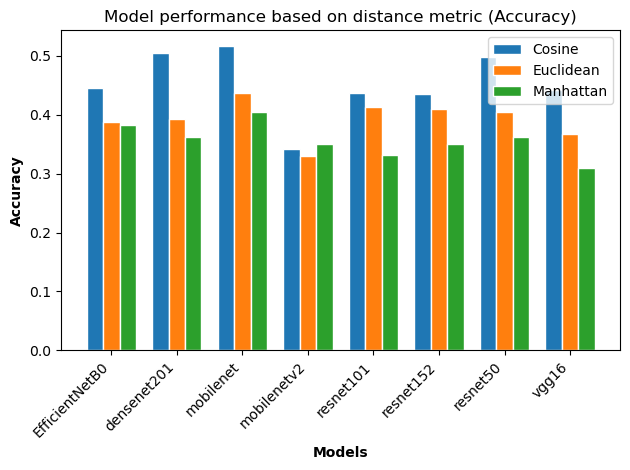

In [6]:
df[['Model', 'Distance']] = pd.DataFrame(df['Model & distance'].tolist(), index=df.index)
df.drop('Model & distance', axis=1, inplace=True)

# Pivot the dataframe for plotting
plot_df = df.pivot(index='Model', columns='Distance', values='Accuracy')

# Define the data
models = plot_df.index.tolist()
cosine = plot_df['cosine'].tolist()
euclidean = plot_df['euclidean'].tolist()
manhattan = plot_df['manhattan'].tolist()

barWidth = 0.25
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create bars
plt.bar(r1, cosine, width=barWidth, edgecolor='white', label='Cosine')
plt.bar(r2, euclidean, width=barWidth, edgecolor='white', label='Euclidean')
plt.bar(r3, manhattan, width=barWidth, edgecolor='white', label='Manhattan')

# Title & Subtitle
plt.title("Model performance based on distance metric (Accuracy)")
plt.xlabel("Models", fontweight='bold')
plt.ylabel("Accuracy", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cosine))], models, rotation=45, ha='right')

# Create legend & Show graphic
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("model_performance_plot.png", dpi=300)
plt.show()

In [7]:
from components.ModelParamsCounter import ModelParamsCounter

model_names = ["resnet50", "resnet101", "resnet152", "densenet201", "vgg16", "mobilenet", "EfficientNetB0", "mobilenetv2"]

param_counts = {}
counter = ModelParamsCounter()

for model_name in model_names:
    model = counter.get_model(model_name)
    param_counts[model_name] = counter.get_total_params(model)

param_df = pd.DataFrame(list(param_counts.items()), columns=["Model Name", "Total Parameters"])
print(param_df)


       Model Name  Total Parameters
0        resnet50          23587712
1       resnet101          42658176
2       resnet152          58370944
3     densenet201          18321984
4           vgg16          14714688
5       mobilenet           3228864
6  EfficientNetB0           4049571
7     mobilenetv2           2257984


## Error analysis

In [8]:
evaluator = SimilarityEvaluator("resnet50", "val_data", "feat", "cosine")
evaluator.print_mismatched_pairs(val_dict)


Left image: COMP90086_2023_TLLdataset/train/left/yfj.jpg, Mismatched Right images: ['COMP90086_2023_TLLdataset/train/right/rsc.jpg', 'COMP90086_2023_TLLdataset/train/right/jub.jpg']
Left image: COMP90086_2023_TLLdataset/train/left/qpb.jpg, Mismatched Right images: ['COMP90086_2023_TLLdataset/train/right/dgn.jpg', 'COMP90086_2023_TLLdataset/train/right/vdi.jpg']
Left image: COMP90086_2023_TLLdataset/train/left/mgi.jpg, Mismatched Right images: ['COMP90086_2023_TLLdataset/train/right/pju.jpg', 'COMP90086_2023_TLLdataset/train/right/hot.jpg']
Left image: COMP90086_2023_TLLdataset/train/left/wng.jpg, Mismatched Right images: ['COMP90086_2023_TLLdataset/train/right/gwi.jpg', 'COMP90086_2023_TLLdataset/train/right/age.jpg']
Left image: COMP90086_2023_TLLdataset/train/left/awg.jpg, Mismatched Right images: ['COMP90086_2023_TLLdataset/train/right/wpa.jpg', 'COMP90086_2023_TLLdataset/train/right/ein.jpg']
Left image: COMP90086_2023_TLLdataset/train/left/rda.jpg, Mismatched Right images: ['COMP9

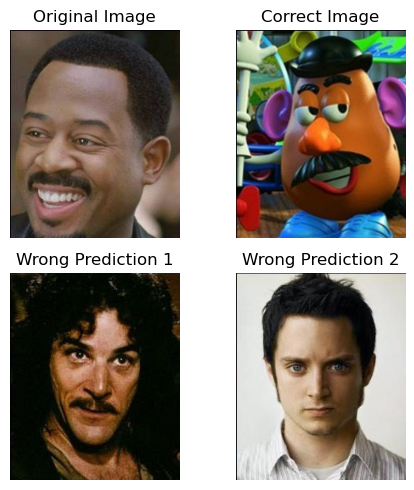

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

def display_images(original, correct, wrong1, wrong2):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1,1])
    
    ax0 = plt.subplot(gs[0])
    ax0.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax0.set_title('Original Image')
    ax0.axis('off')  # Hide the axes ticks/labels
    
    ax1 = plt.subplot(gs[1])
    ax1.imshow(cv2.cvtColor(correct, cv2.COLOR_BGR2RGB))
    ax1.set_title('Correct Image')
    ax1.axis('off')  # Hide the axes ticks/labels
    
    ax2 = plt.subplot(gs[2])
    ax2.imshow(cv2.cvtColor(wrong1, cv2.COLOR_BGR2RGB))
    ax2.set_title('Wrong Prediction 1')
    ax2.axis('off')  # Hide the axes ticks/labels
    
    ax3 = plt.subplot(gs[3])
    ax3.imshow(cv2.cvtColor(wrong2, cv2.COLOR_BGR2RGB))
    ax3.set_title('Wrong Prediction 2')
    ax3.axis('off')  # Hide the axes ticks/labels
    
    plt.tight_layout()
    plt.show()

# Load images (assuming they are in BGR format as loaded by OpenCV)
original = cv2.imread('COMP90086_2023_TLLdataset/train/left/eoq.jpg')
correct = cv2.imread('COMP90086_2023_TLLdataset/train/right/ujr.jpg')
wrong1 = cv2.imread('COMP90086_2023_TLLdataset/train/right/ojd.jpg')
wrong2 = cv2.imread('COMP90086_2023_TLLdataset/train/right/xwa.jpg')

# Call the function to display images
display_images(original, correct, wrong1, wrong2)


# Get predictions and export to scv file

In [17]:
import os
import csv
import numpy as np

def compute_similarity(vec1, vec2, metric='cosine'):
    """Compute similarity between two vectors."""
    # Flatten the vectors
    vec1_flat = vec1.flatten()
    vec2_flat = vec2.flatten()

    if metric == 'cosine':
        dot_product = np.dot(vec1_flat, vec2_flat)
        norm_a = np.linalg.norm(vec1_flat)
        norm_b = np.linalg.norm(vec2_flat)
        similarity = dot_product / (norm_a * norm_b)
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    return similarity

# Load features
def load_saved_features(model_name, set_name, side, base_dir="feat"):
    features_file_path = os.path.join(base_dir, model_name, set_name, f"{set_name}_{side}_features.pkl")
    with open(features_file_path, 'rb') as f:
        features_dict = pickle.load(f)
    return features_dict

# Create a dictionary to store similarity scores
similarity_scores = {}

# Load the saved features for mobileNet
test_left = load_saved_features("mobileNet", "test_data", "left")
test_right = load_saved_features("mobileNet", "test_data", "right")

# Iterate through the rows of the CSV file
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        left_image = row['left']
        right_images = [row[f'c{i}'] for i in range(20)]
        
        scores = []  # List to store similarity scores for the current left image
        
        # Iterate through the right images
        for right_image in right_images:
            left_image_path = os.path.join('COMP90086_2023_TLLdataset/test/left', left_image)
            right_image_path = os.path.join('COMP90086_2023_TLLdataset/test/right', right_image)
            
            left_features = test_left[left_image_path + '.jpg']
            right_features = test_right[right_image_path + '.jpg']
            
            # Compute the similarity between the left and right images
            similarity = compute_similarity(left_features, right_features)
            scores.append(similarity)
        
        # Add the scores to the dictionary with the left image as the key
        similarity_scores[left_image] = scores

# Write the similarity scores to a new CSV file
with open('similarity_scores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    header_row = ['left'] + [f'c{i}' for i in range(20)]
    writer.writerow(header_row)

    # Write the similarity scores for each left image
    for left_img, scores in similarity_scores.items():
        writer.writerow([left_img] + scores)
